# Data exploration and cleaning, creating features as we go

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy import stats

# mongo
from pymongo import MongoClient

# nltk for natural language processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# sklearn 
# vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

# similarity metric
from sklearn.metrics.pairwise import cosine_similarity

from data_visualization import plot_categorical_log

In [3]:
client = MongoClient('mongodb://localhost:27017/')
db = client.nebflix

data = db.movies.find()

df =  pd.DataFrame(list(data))
df.shape

(1343, 10)

In [7]:
# I acquired this dataset myself from the IMDB website using a selenium webscraper
df = pd.read_csv("MovieLensFilteredData/ScrapedMoviedData.csv")

# drop the weird column
# df = df.drop(columns='Unnamed: 0', axis=1)

# df = df.loc[df['Votes'] >= 100000] # keep movies with more than 100000 votes in IMDB, keeps popular movies 
df.shape

(1343, 10)

In [8]:
df.head(1)

,_id,actors,director,genres,image_link,imdbId,movieId,storyline,title,year
0,5eca5fb277b8f542e37ac59c,"['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...",John Lasseter,"['Animation', 'Adventure', 'Comedy', '22 March...",https://m.media-amazon.com/images/M/MV5BMDU2ZW...,114709,1,A little boy named Andy loves to be in his...,Toy Story,1995


# Check for NA values

In [4]:
print("Number of rows with NA: {n}".format(n=len(df[df.isna().any(axis=1)])))
print("Columns with NA: {n}".format(n=df.columns[df.isna().any()].tolist()))

Number of rows with NA: 0
Columns with NA: []


# Genre

In [5]:
print(df.genres.iloc[0])
print(type(df.genres.iloc[0]))

['Animation', 'Adventure', 'Comedy']
<class 'list'>


- The genre column looks like a list but it is a string
- We want a list so we will have to clean it up
- We will create new column, count of genres in each movie
- Display the most popular genres

Number of different genres: 23

Top 1 genre: Drama: count: 633
Top 2 genre: Comedy: count: 485
Top 3 genre: Action: count: 379
Top 4 genre: Adventure: count: 370
Top 5 genre: Crime: count: 244
Top 6 genre: Thriller: count: 210
Top 7 genre: Romance: count: 188
Top 8 genre: Sci-Fi: count: 180
Top 9 genre: Fantasy: count: 140
Top 10 genre: Mystery: count: 121
Top 11 genre: Family: count: 100
Top 12 genre: Animation: count: 91
Top 13 genre: Biography: count: 90
Top 14 genre: Horror: count: 83
Top 15 genre: History: count: 37
Top 16 genre: Music: count: 30
Top 17 genre: Sport: count: 27
Top 18 genre: War: count: 27
Top 19 genre: Musical: count: 15
Top 20 genre: Western: count: 13
Top 21 genre: Film-Noir: count: 8
Top 22 genre: Documentary: count: 6
Top 23 genre: Short: count: 3


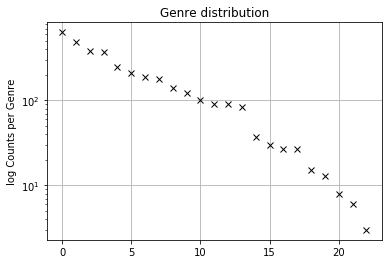

In [8]:
# apply the regex to all rows in our dataset
# df['Genres_clean'] = [re.findall(r'[A-Z][A-z- ]+', genre_string) for genre_string in df.Genres] # Use a regex findall to convert our string to a list
# df['Number_of_genres'] = df['Genres_clean'].apply(lambda genre_list: len(genre_list)) # Create column with number of genres in each movie

# df['clean_genre'] = [re.sub(r"[\[\'\" ]+", '', i) for i in df['genres']]

# df['clean_genre'] = [i.split(',')[:-1] for i in df['clean_genre']]

# print("Example of cleaned genres: {n}\n".format(n=df['Genres_clean'].iloc[0]))

df['num_genre'] = [len(i) for i in df['genres']]


genres_expanded = pd.Series([genre for row in df.genres for genre in row]) # expand our genres column, turning a list of lists into one long pandas series
print("Number of different genres: {n}\n".format(n=len(genres_expanded.unique())))

counts_per_genre = genres_expanded.value_counts(sort=True) # get value counts of our expanded genres series

# print top 5 genres
for i in range(23):
    print("Top {i} genre: {name}: count: {num}".format(i=i+1, 
                                                       name=counts_per_genre.index.tolist()[i], 
                                                       num=counts_per_genre.tolist()[i]))

# call function from data_visualization.py
plot_categorical_log(counts_per_genre, "Genre")

In [9]:
df['num_genre'].mean()

2.5912137006701417

In [10]:
len(counts_per_genre)

23

## The IMDB website describes genres as either subjective or objective. 
###### https://help.imdb.com/article/contribution/titles/genres/GZDRMS6R742JRGAG?ref_=helpart_nav_31#

I will encode the Objective genres with binary values. They include; Animation, Biography, Documentary, Family, Film-Noir, History, Musical, Short, Sport, War, Western. 
- A movie listed as 'Biography' will receive a value of 1 in the Biography column
- A movie listed as 'Biography'and 'War' will receive a value of 1 in the Biography and War columns

I will encode the Subjective genres with a weighted value depending on how many subjective genres are listed with the movie. They include; Adventure, Drama, Comedy, Thriller, Action, Romance, Crime, Sci-Fi, Fantasy, Mystery, Horror, Music
- A movie listed as only 'Drama' will receive a value of 1.0 in the Drama column.
- A movie listed as 'Drama' and 'Romance' will receive a value of 0.5 in the respective column.
- A movie listed as 'Biography', 'Drama' and 'Romance' will receive a value of 1 for Biography(Objective) and a value of 0.5 in 'Drama' and 'Romance'

In [13]:
# Split the genres column into subjective and objective columns

# initialise our objective and subjetive genre lists
obj = ['Animation', 'Biography', 'Documentary', 'Family', 'Film-Noir', 'History',
       'Musical', 'Short', 'Sport', 'War', 'Western']

subj = ['Adventure', 'Drama', 'Comedy', 'Thriller', 'Action', 'Romance', 
        'Crime', 'Sci-Fi', 'Fantasy', 'Mystery', 'Horror', 'Music']

# methods to split the genres column into subjective and objective columns respectively
# I had issue with creating two columns in the df with one method so I had to seperate them
def split_genres_obj(genres):
    obj_g = []
    
    for g in genres:
        if g in obj:
            obj_g.append(g)
    return obj_g

def split_genres_subj(genres):
    subj_g = []
    
    for g in genres:
        if g in subj:
            subj_g.append(g)
    return subj_g


df['objective_genres'] = df.genres.apply(lambda genres: split_genres_obj(genres)) # create objective column
df['subjective_genres'] = df.genres.apply(lambda genres: split_genres_subj(genres)) # create subjective column

df['number_subjective_genres'] = df.subjective_genres.apply(lambda subjg: len(subjg)) # create column with number of subjective genres for later use

df[['genres', 'objective_genres', 'subjective_genres']].head(1)

,genres,objective_genres,subjective_genres
0,"[Animation, Adventure, Comedy]",[Animation],"[Adventure, Comedy]"


## Encode our genres

In [14]:
mlb = MultiLabelBinarizer()

# Enocde the objective genres with values of 1 and 0
obj_genre_df = pd.DataFrame(mlb.fit_transform(df.objective_genres),
                          columns=mlb.classes_,
                          index=df.index)

# Enocde the subjective genres with weighted values
subj_genre_df = pd.DataFrame(mlb.fit_transform(df.subjective_genres),
                          columns=mlb.classes_,
                          index=df.index)

subj_genre_df.head()

,Action,Adventure,Comedy,Crime,Drama,Fantasy,Horror,Music,Mystery,Romance,Sci-Fi,Thriller
0,0,1,1,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,1,0,0
4,0,0,0,1,1,0,0,0,0,0,0,1


In [15]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Enocde the objective genres with values of 1 and 0
obj_genre_df = pd.DataFrame(mlb.fit_transform(df.objective_genres),
                          columns=mlb.classes_,
                          index=df.index)

# Enocde the subjective genres with weighted values
subj_genre_df = pd.DataFrame(mlb.fit_transform(df.subjective_genres),
                          columns=mlb.classes_,
                          index=df.index)

subj_genre_df['count'] = df['number_subjective_genres']
# divide binary value by count
subj_genre_df = subj_genre_df.loc[:,"Action":"Thriller"].div(subj_genre_df["count"], axis=0)

genre_df = pd.concat([obj_genre_df,subj_genre_df], axis=1)

# genre_df['title'] = df['title']
genre_df['movieId'] = df['movieId']

genre_df = genre_df.fillna(0) # some movies get na values when we divided by a count of 0 for subjective genres
genre_df.head(1)

,Animation,Biography,Documentary,Family,Film-Noir,History,Musical,Short,Sport,War,...,Crime,Drama,Fantasy,Horror,Music,Mystery,Romance,Sci-Fi,Thriller,movieId
0,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [17]:
print("NA values: {n}".format(n=len(genre_df[genre_df.isnull().any(axis=1)])))

NA values: 0


In [16]:
# save df for future use
genre_df.to_pickle('Pickles/genre_df.pkl')

# Actor

In [20]:
# what the column currently looks like
print(df.actors.iloc[0])
print(type(df.actors.iloc[0]))

['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim Varney', 'Wallace Shawn', 'John Ratzenberger', 'Annie Potts', 'John Morris', 'Erik von Detten', 'Laurie Metcalf', 'R. Lee Ermey', 'Sarah Freeman', 'Penn Jillette', 'Jack Angel', 'Spencer Aste']
<class 'list'>


In [21]:
# df['clean_actor'] = [re.sub(r'[\"\[\]\']', '', actors_string).split(', ') for actors_string in df.actors]

df['num_actors'] = [len(i) for i in df['actors']]


df['num_actors'].describe()

count    1343.000000
mean       14.711095
std         1.342281
min         1.000000
25%        15.000000
50%        15.000000
75%        15.000000
max        15.000000
Name: num_actors, dtype: float64

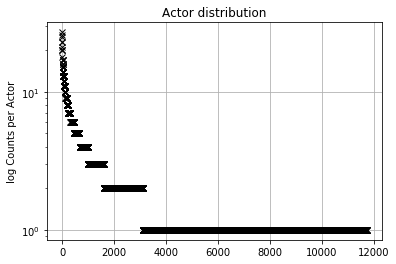

Number of actors: 11716

Top 1 actor: Robert De Niro: count: 27
Top 2 actor: Brad Pitt: count: 26
Top 3 actor: Samuel L. Jackson: count: 25
Top 4 actor: Morgan Freeman: count: 23
Top 5 actor: Bill Murray: count: 23


In [22]:
actors_expanded = pd.Series([i for row in df.actors for i in row])
counts_per_actor = actors_expanded.value_counts(sort=True)

# call function from data_visualization.py
plot_categorical_log(counts_per_actor, 'Actor')

print("Number of actors: {num}\n".format(num=len(actors_expanded.unique())))

for i in range(5):
    print("Top {i} actor: {name}: count: {num}".format(i=i+1, 
                                                       name=counts_per_actor.index.tolist()[i], 
                                                       num=counts_per_actor.tolist()[i]))

In [53]:
len(counts_per_actor[counts_per_actor == 1])

8616

In [25]:
mlb = MultiLabelBinarizer()
actor_df = pd.DataFrame(mlb.fit_transform(df.actors),
                          columns=mlb.classes_,
                          index=df.index)

# like production companies, we will remove the actors with only 1 movie
first_single_count_actor = np.where(counts_per_actor==1)[0].min()

actor_to_keep = counts_per_actor[0:first_single_count_actor].index.tolist() # we are keeping the production companies with >1 movie

actor_df = actor_df[actor_to_keep] # filter out ones we don't want

num_actors = len([i for i in actor_df.sum(axis = 1, skipna = True).tolist() if i==0])
print("Movies with no actor represented: {p}%".format(p=100*(round(num_actors/len(actor_df), 2))))

# actor_df['title'] = df['title']
actor_df['movieId'] = df['movieId']

actor_df.shape

Movies with no actor represented: 1.0%


(1343, 3101)

In [26]:
num_actors

13

In [27]:
actor_df.to_pickle('Pickles/actor_df.pkl')

# Director

Number of movies: 1343
Number of director: 589

Top 1 actor: Steven Spielberg: count: 20
Top 2 actor: Tim Burton: count: 14
Top 3 actor: Ron Howard: count: 11
Top 4 actor: Ridley Scott: count: 11
Top 5 actor: Martin Scorsese: count: 10


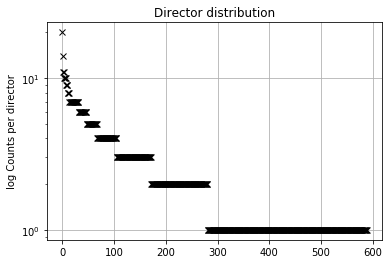

In [28]:
print("Number of movies: {num}".format(num=len(df)))
print("Number of director: {num}\n".format(num=len(df.director.unique())))

counts_per_director = df.director.value_counts(sort=True)

for i in range(5):
    print("Top {i} actor: {name}: count: {num}".format(i=i+1, 
                                                       name=counts_per_director.index.tolist()[i], 
                                                       num=counts_per_director.tolist()[i]))
    
# call function from data_visualization.py
plt.plot(np.arange(len(counts_per_director)), counts_per_director, 'xk')
plt.gca().set_yscale('log')
plt.title('Director distribution')
plt.ylabel('log Counts per director')
plt.grid('on')
plt.show()

In [29]:
# plot the percentage of movies covered by top n actors

director_df = pd.get_dummies(df.director) # one hot encode the director column

# like before, we will remove the directors with only 1 movie
first_single_count_director = np.where(counts_per_director==1)[0].min()

director_to_keep = counts_per_director[0:first_single_count_director].index.tolist() # we are keeping the directors with >1 movie

director_df = director_df[director_to_keep] # filter out ones we don't want

# sum over the column axis. 
num_directors = len([i for i in director_df.sum(axis = 1, skipna = True).tolist() if i==0])
# director_df['title'] = df['title']
director_df['movieId'] = df['movieId']


print("Movies with no director represented: {p}%".format(p=100*(round(num_directors/len(director_df), 2))))
print(director_df.shape)

Movies with no director represented: 23.0%
(1343, 282)


In [30]:
num_directors

308

- the high number of samples with no director is likely caused by our filtering out movies with less than 100000 votes on imdb. The movies with less votes are less popular and may have been directed by obscure directors

In [31]:
director_df.to_pickle('Pickles/director_df.pkl')

# Storyline

496.2486969471333


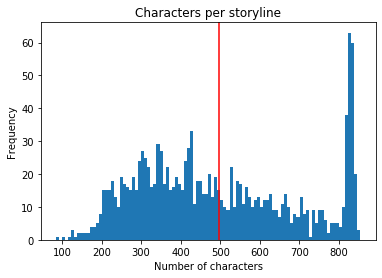

In [32]:
chars_per_storyline = np.array([len(i.replace(' ', '')) for i in df.storyline])

df['storyline_chars'] = chars_per_storyline

# fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14, 4), sharey=False, sharex=False)  # 1 row, 2 columns

print(chars_per_storyline.mean())
plt.hist(x=chars_per_storyline, bins=100)
plt.title('Characters per storyline')
plt.ylabel("Frequency")
plt.xlabel("Number of characters")
plt.axvline(chars_per_storyline.mean(), c='red')
# ax1.grid('on')

# ax2.hist(x=chars_per_storyline, bins=100, range=(900,1050))
# ax2.set_title('Histogram, characters per storyline [cropped range]')

plt.show()

- The abrupt stop in the counts of characters in the storyline is likely due to max characters for the storyline on IMDB

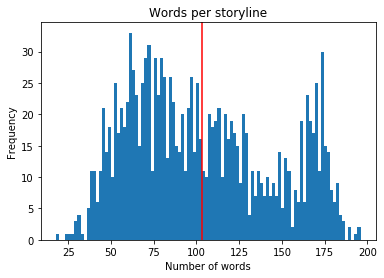

In [33]:
words_per_storyline = np.array([len(i.split()) for i in df.storyline])
df['storyline_words'] = words_per_storyline

plt.hist(x=words_per_storyline, bins=100)
plt.title('Words per storyline')
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.axvline(words_per_storyline.mean(), c='red')
plt.show()

In [34]:
mean_words = int(df.storyline_words.mean())
print("Mean number of words in Storyline: {n}".format(n=mean_words))
mean_chars = int(df.storyline_chars.mean())
print("Mean number of chars in Storyline: {n}".format(n=mean_chars))

Mean number of words in Storyline: 103
Mean number of chars in Storyline: 496


- Nothing unusual in the distribution of the words in Storyline
- The difference between the character and word count is interesting. The characters abruptly stop. May be due to there being lots of combinations of varaying length words to reach max characters

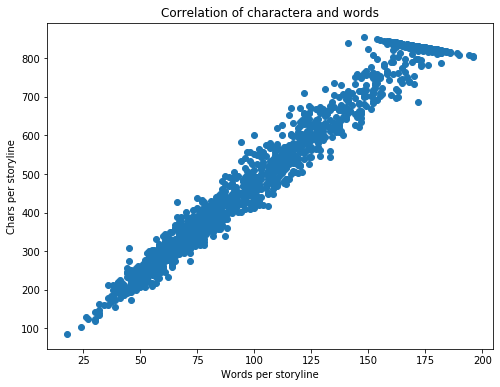

In [35]:
plt.figure(figsize=(8,6))
plt.scatter(words_per_storyline, chars_per_storyline)
plt.title('Correlation of charactera and words')
plt.xlabel("Words per storyline")
plt.ylabel("Chars per storyline")
plt.show()

In [36]:
words_per_storyline[:20]

array([146,  44,  99,  95, 129, 134,  95, 124, 150, 120, 122, 127,  46,
        47, 147,  84,  77,  42,  65, 175])

In [37]:
stats.pearsonr(chars_per_storyline, words_per_storyline)

(0.9844561783538487, 0.0)

## We will use the Storyline to engineer text features

In [38]:
# nltk.download('punkt')
# nltk.download('stopwords')

# Remove punctuation
df['storyline_no_punct'] = df['storyline'].apply(lambda row: re.sub(r'[\',.\"\(\)\\]', '', row))

# tokenize
df['storyline_tokens'] = df['storyline_no_punct'].apply(lambda row: word_tokenize(row))

# lower all the tokens
df['storyline_tokens'] = df['storyline_tokens'].apply(lambda row: [i.lower() for i in row])

# view results
df[['storyline', 'storyline_tokens']].iloc[0]

# remove stopwords
stop_words = stopwords.words("english")
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

df['storyline_tokens'] = df['storyline_tokens'].apply(lambda row: remove_stopwords(row))

df[['storyline', 'storyline_tokens']].head(1)

,storyline,storyline_tokens
0,A little boy named Andy loves to be in his...,"[little, boy, named, andy, loves, room, playin..."


## Stemming

In [39]:
ss_en = SnowballStemmer('english')

def stem_words(tokens):
    return [ss_en.stem(i) for i in tokens]

df['storyline_tokens_stem'] = df['storyline_tokens'].apply(
                                        lambda row: stem_words(row))
    
df[['storyline', 'storyline_tokens_stem']].head(1)

,storyline,storyline_tokens_stem
0,A little boy named Andy loves to be in his...,"[littl, boy, name, andi, love, room, play, toy..."


In [40]:
def token_to_sentence(tokens):
    return ' '.join(word for word in tokens)

df['storyline_stem'] = df['storyline_tokens_stem'].apply(lambda row: token_to_sentence(row))

In [41]:
print("Rows with NA: {n}:".format(n=len(df[df.isnull().any(axis=1)])))

Rows with NA: 0:


In [42]:
df.head(1)

,_id,actors,director,genres,image_link,imdbId,movieId,storyline,title,year,...,objective_genres,subjective_genres,number_subjective_genres,num_actors,storyline_chars,storyline_words,storyline_no_punct,storyline_tokens,storyline_tokens_stem,storyline_stem
0,5ed66dfb872e7d29663e0867,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter,"[Animation, Adventure, Comedy]",https://m.media-amazon.com/images/M/MV5BMDU2ZW...,0114709,1,A little boy named Andy loves to be in his...,Toy Story,1995,...,[Animation],"[Adventure, Comedy]",2,15,622,146,A little boy named Andy loves to be in his...,"[little, boy, named, andy, loves, room, playin...","[littl, boy, name, andi, love, room, play, toy...",littl boy name andi love room play toy especi ...


In [43]:
original = df.iloc[0]['storyline']
len(set(original.split(' ')))

100

In [44]:
updated = df.iloc[0]['storyline_stem']
len(set(updated.split(' ')))

50

In [45]:
updated

'littl boy name andi love room play toy especi doll name woodi toy andi come life woodi believ life toy good howev must worri andi famili move woodi know andi birthday parti woodi realiz andi mother gave action figur known buzz lightyear believ toy quick becom andi new favorit toy woodi consum jealousi tri get rid buzz woodi buzz lost must find way get back andi move without pass ruthless toy killer sid phillip'

## Vectorization

In [46]:
text_data = df['storyline_stem']
text_data_array = np.array(text_data)

# And now testing TFIDF vectorizer:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data_array)

In [47]:
# Get feature names
feature_names = tfidf_vectorizer.get_feature_names()
print("Number of features %s" % len(feature_names))

Number of features 5800


In [48]:
# create df from our tfidf matrix
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = feature_names)
# tfidf_df['title'] = df['title']
tfidf_df['movieId'] = df['movieId']



In [49]:
tfidf_df.head(5)

,00,007,10,100,1000,100000,10th,11,12,13,...,zebra,zeke,zellweg,zero,zeta,zion,zombi,zone,zoo,movieId
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


In [50]:
tfidf_df[["woodi"  ,"woolli"  , 
"word"     ,  
"work"      ,
"worker"    ,
"working"    ,
"workplac"  ,
"world"      , 
"worldwid"  ,
"worm"      ,
"wormhol"   ,
"worri"   ,
"wors"     ]].head(1)

,woodi,woolli,word,work,worker,working,workplac,world,worldwid,worm,wormhol,worri,wors
0,0.52017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071706,0.0


In [51]:
tfidf_df.iloc[0][5721:5750]

wizardri    0.000000
wolf        0.000000
wolv        0.000000
wolverin    0.000000
woman       0.000000
women       0.000000
wonder      0.000000
wonka       0.000000
wont        0.000000
woo         0.000000
wood        0.000000
wooden      0.000000
woodhous    0.000000
woodi       0.520170
woolli      0.000000
word        0.000000
work        0.000000
worker      0.000000
working     0.000000
workplac    0.000000
world       0.000000
worldwid    0.000000
worm        0.000000
wormhol     0.000000
worri       0.071706
wors        0.000000
worsen      0.000000
worship     0.000000
worst       0.000000
Name: 0, dtype: float64

In [52]:
tfidf_df.to_pickle('Pickles/tfidf_df.pkl')

# Remove the irregular movieId

In [3]:
movies = pd.read_csv('MovieLensFilteredData/moviesFiltered.csv')
movies.head(1)

,movieId,title,genres,imdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709


In [4]:

movies = movies.loc[movies['imdbId']!=118114]
movies.to_csv('MovieLensFilteredData/moviesFiltered.csv', index=False)
